In [79]:
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix
from tqdm import tqdm
import numpy as np
import implicit
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization

In [80]:
ratings = pd.read_csv('Dataset/ratings.csv')
movies = pd.read_csv('Dataset/movies.csv')
merged_df = pd.merge(ratings, movies, on='movieId')

/var/folders/7d/6vkdm1d14cb750fkmntf7gvw0000gn/T/ipykernel_75422/474964804.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


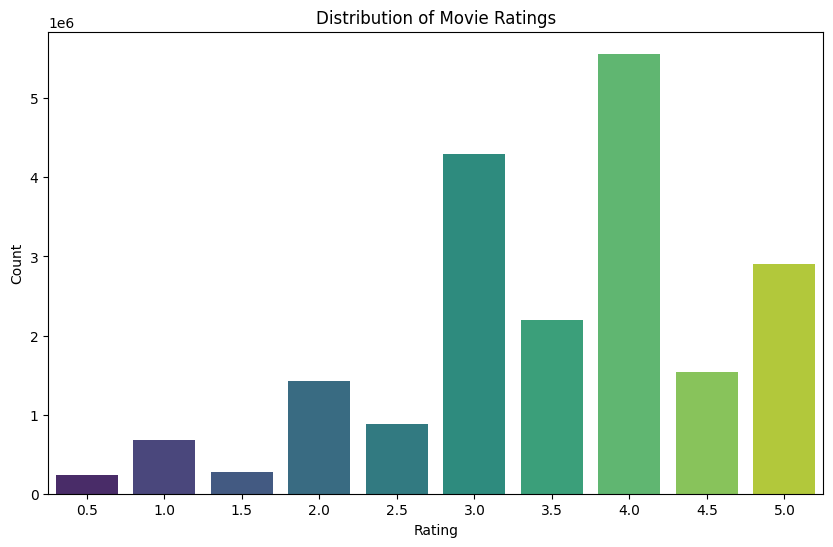

In [81]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

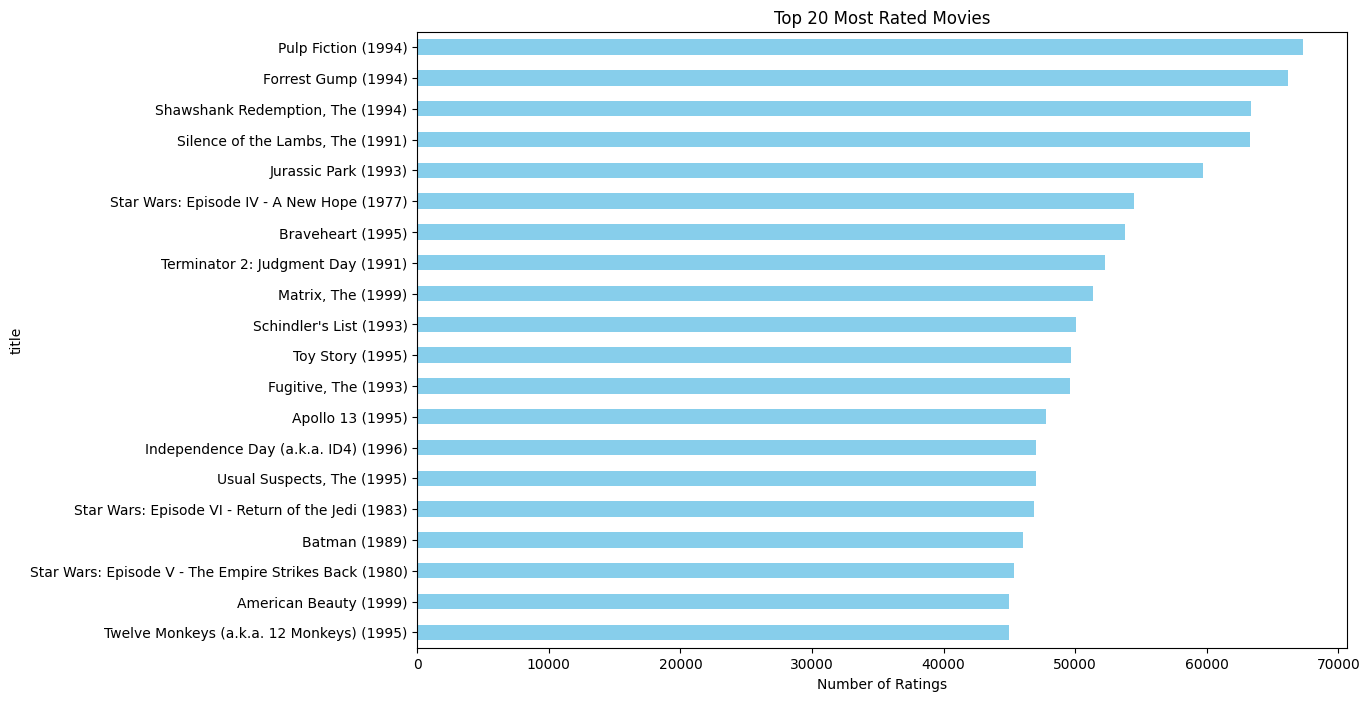

In [85]:
ratings_per_movie = merged_df.groupby('title').size().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
ratings_per_movie[:20].plot(kind='barh', color='skyblue')
plt.title('Top 20 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.gca().invert_yaxis()
plt.show()

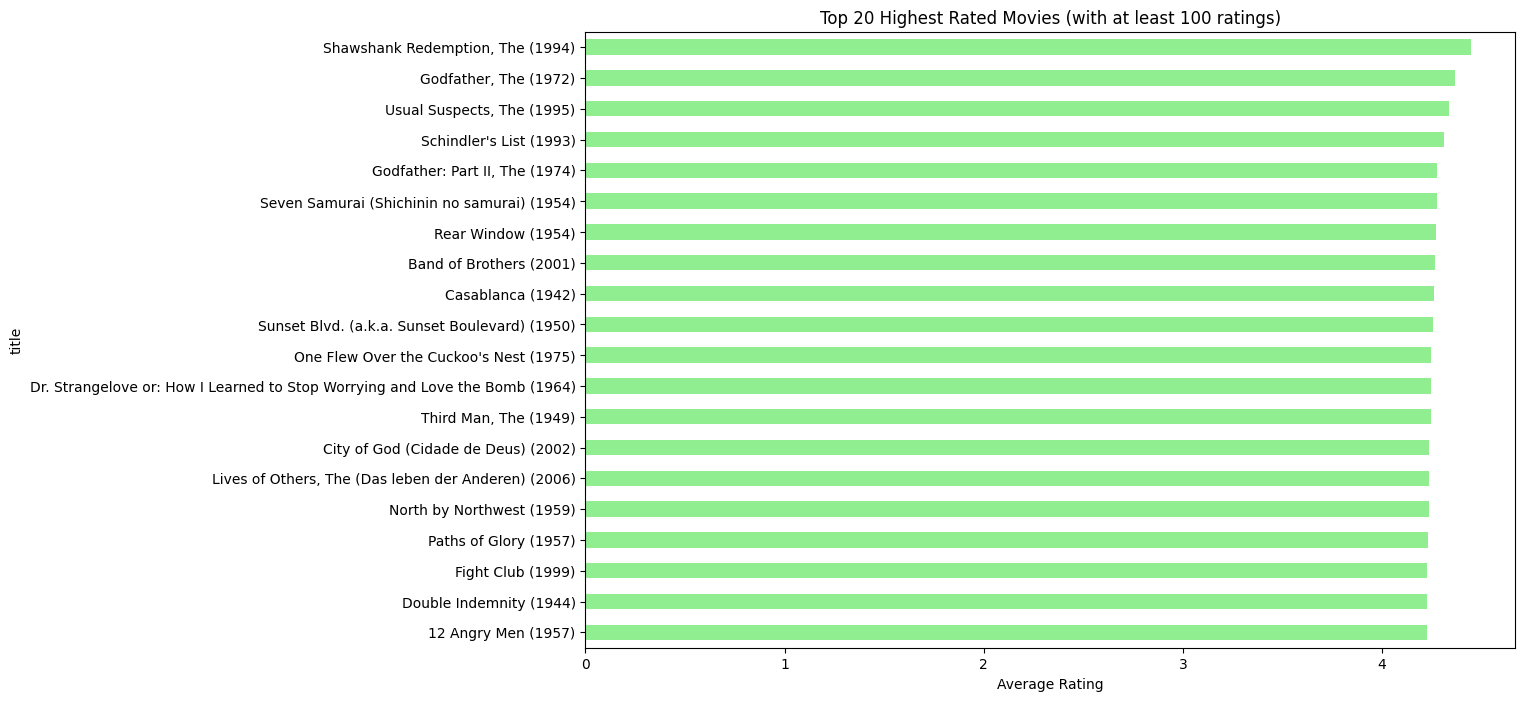

In [86]:
avg_ratings = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False)

top_rated_movies = merged_df.groupby('title').filter(lambda x: len(x) >= 100)
top_avg_ratings = top_rated_movies.groupby('title')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
top_avg_ratings[:20].plot(kind='barh', color='lightgreen')
plt.title('Top 20 Highest Rated Movies (with at least 100 ratings)')
plt.xlabel('Average Rating')
plt.gca().invert_yaxis()
plt.show()

/var/folders/7d/6vkdm1d14cb750fkmntf7gvw0000gn/T/ipykernel_75422/398600650.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='year', data=merged_df, palette='coolwarm')


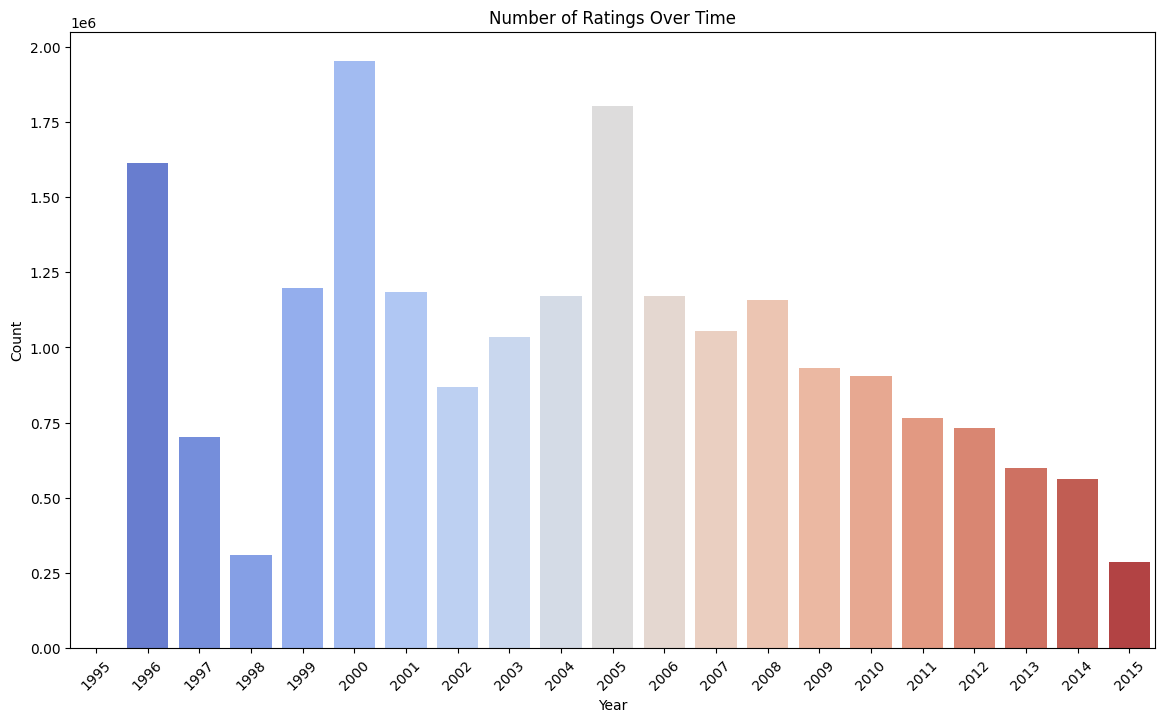

In [87]:
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='s')

merged_df['year'] = merged_df['timestamp'].dt.year

plt.figure(figsize=(14, 8))
sns.countplot(x='year', data=merged_df, palette='coolwarm')
plt.title('Number of Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

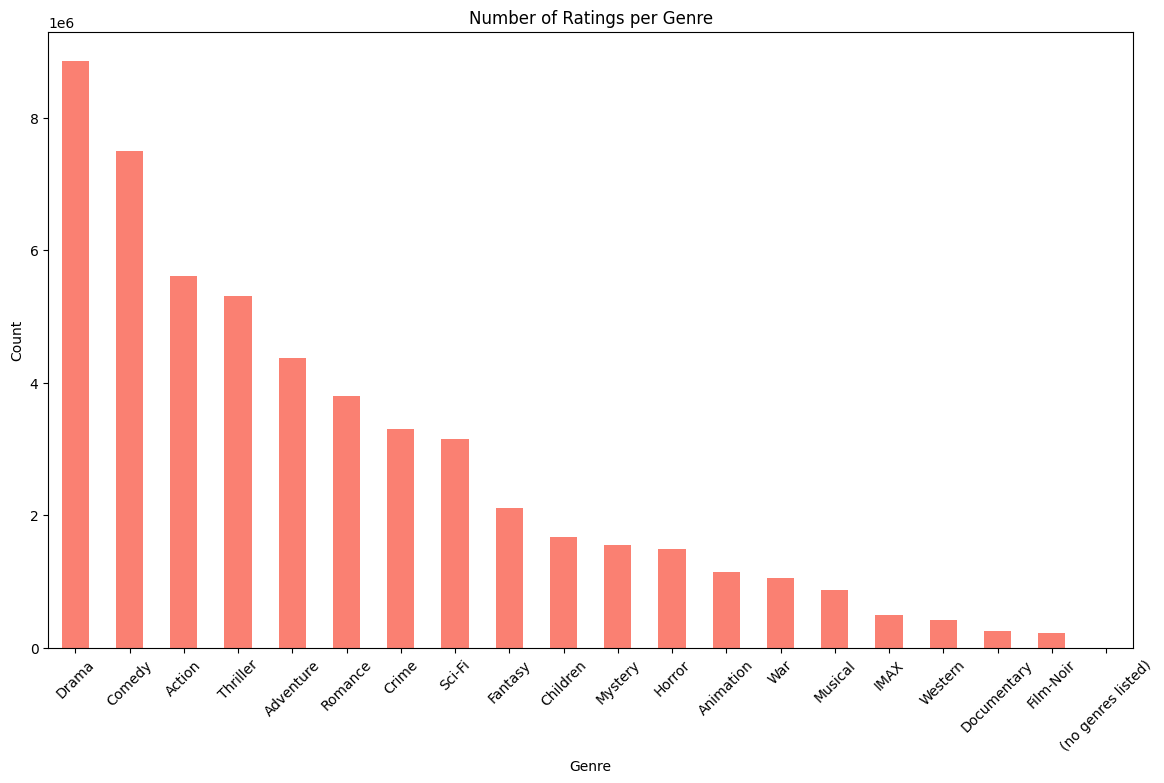

In [88]:
genres_df = merged_df[['movieId', 'title', 'genres']].copy()
genres_df = genres_df.assign(genres=genres_df['genres'].str.split('|')).explode('genres')

ratings_per_genre = genres_df.groupby('genres').size().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
ratings_per_genre.plot(kind='bar', color='salmon')
plt.title('Number of Ratings per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# LSH and Bucketing

In [75]:
rating_df = pd.read_csv('Dataset/ratings.csv').astype(int)
rating_df

,userId,movieId,rating,timestamp
0,1,2,3,1112486027
1,1,29,3,1112484676
2,1,32,3,1112484819
3,1,47,3,1112484727
4,1,50,3,1112484580
...,...,...,...,...
20000258,138493,68954,4,1258126920
20000259,138493,69526,4,1259865108
20000260,138493,69644,3,1260209457
20000261,138493,70286,5,1258126944


In [3]:
def create_sparse_matrix(data):
    pivot_table = data.pivot(index='userId', columns='movieId', values='normalized_rating').fillna(0)
    return csr_matrix(pivot_table.values)

def normalize_data(data):
    mean_ratings = data.groupby('userId')['rating'].mean().reset_index(name='mean_rating')
    data = data.merge(mean_ratings, on='userId')
    data['normalized_rating'] = data['rating'] - data['mean_rating']
    data.drop(columns=['rating', 'mean_rating'], inplace=True, errors='ignore')
    return data, mean_ratings

In [4]:
def create_hash_vectors(length: int, count: int) -> list:
    return [np.random.uniform(-1, 1, size=length) for _ in range(count)]
        
def create_hash(vector: list, min_hash):
    result = []
    for hash in min_hash:
        a = np.dot(vector, hash) > 0
        result.append(1 if a else 0)
    return result

In [5]:
def calculate_bucket_number(hash_vector):
    s = ''.join(str(bit) for bit in hash_vector)
    bucket_number = int(s, 2)
    return bucket_number

# Neighbourhood Matrix

In [6]:
def create_neighborhood_matrix(new_user_vector, buckets, min_hash, sparse_matrix) -> csr_matrix:
    hash_vector = create_hash(new_user_vector, min_hash)
    bucket_number = calculate_bucket_number(hash_vector)

    if bucket_number in buckets:
        neighbor_users = buckets[bucket_number]
    else:
        return csr_matrix((0, sparse_matrix.shape[1]))
    
    rows = [sparse_matrix[n].toarray()[0] for n in neighbor_users]
    return csr_matrix(np.vstack(rows)) if rows else csr_matrix((0, sparse_matrix.shape[1]))

In [99]:
# def matrix_factorization(sparse_ratings: csr_matrix):
#     model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=64, use_native=True, num_threads=0)
#     model.fit(sparse_ratings.T, show_progress=False)
#     user_factors = model.user_factors
#     item_factors = model.item_factors
#     return item_factors @ user_factors.T

# def matrix_factorization(sparse_ratings: csr_matrix, k):
#     U, S, V = scipy.sparse.linalg.svds(sparse_ratings, k=k)
#     item_factors = U.dot(np.diag(S))
#     user_factors = V.T
#     factorization = item_factors.dot(user_factors.T)
#     factorization = item_factors @ user_factors.T
#     return factorization

from sklearn.utils.extmath import randomized_svd

def matrix_factorization(sparse_ratings: csr_matrix, k: int):
    U, S, V = randomized_svd(sparse_ratings, n_components=k)
    item_factors = U.dot(np.diag(S))
    user_factors = V
    factorization = item_factors.dot(user_factors)
    return factorization

# Rating Predictions

In [7]:
def pearson_correlation_coefficient(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must be of the same length")
    
    mean1 = np.mean(array1)
    mean2 = np.mean(array2)
    
    centered1 = array1 - mean1
    centered2 = array2 - mean2
    
    covariance = np.sum(centered1 * centered2) / len(array1)
    std_dev1 = np.sqrt(np.sum(centered1**2) / len(array1))
    std_dev2 = np.sqrt(np.sum(centered2**2) / len(array2))
    
    if std_dev1 * std_dev2 == 0:
        return 0
    
    pearson_coefficient = covariance / (std_dev1 * std_dev2)
    
    return pearson_coefficient

In [9]:
def predict_ratings(user_vector, similar_users_count, buckets, min_hash, sparse_matrix):
    nm = create_neighborhood_matrix(user_vector, buckets, min_hash, sparse_matrix)
    min_shape = np.min(nm.shape)
    if min_shape == 0:
        return []
    k = int(0.5 * min_shape)
    if k < 1:
        k = 1
    if k == min_shape:
       return [] 
    neighborhood_matrix = matrix_factorization(nm, k)
    
    similarities = np.array([np.abs(pearson_correlation_coefficient(neighborhood_matrix[i], user_vector))
                             for i in range(neighborhood_matrix.shape[0])])
    
    similar_users = similarities.argsort()[::-1]
    user_mean = user_vector[user_vector != 0].mean()
    
    predicts = []
    for item_idx in range(neighborhood_matrix.shape[1]):
        if user_vector[item_idx] == 0:
            predicts.append(0)
            continue
        weighted_ratings_sum = 0
        weights_sum = 0
        users_added = 0
        for user_index in similar_users:
            if users_added == similar_users_count:
                break
            
            user_rating = neighborhood_matrix[user_index, item_idx]
            if user_rating == 0:
                continue
            users_added += 1
            similarity_score = similarities[user_index]
            weighted_ratings_sum += user_rating * similarity_score
            weights_sum += np.abs(similarity_score)
        
        predicted_rating = weighted_ratings_sum / weights_sum if weights_sum > 0 else 0
        predicts.append(predicted_rating + user_mean)
    
    return np.array(predicts)

# Cross Validation

In [10]:
def df_to_sparse(rating_df, df, key= 'normalized_rating'):
    unique_user_ids = pd.Series(rating_df['userId'].unique()).sort_values()
    user_mapping = pd.Series(index=unique_user_ids, data=range(len(unique_user_ids)))

    unique_movie_ids = pd.Series(rating_df['movieId'].unique()).sort_values()
    movie_mapping = pd.Series(index=unique_movie_ids, data=range(len(unique_movie_ids)))
    
    user_indices = df['userId'].map(user_mapping)
    movie_indices = df['movieId'].map(movie_mapping)
    values = df[key]

    result = coo_matrix((values, (user_indices, movie_indices)), 
                    shape=(len(user_mapping), len(movie_mapping)))
    print(result.shape)
    print(result.count_nonzero())
    return result.tocsr()

In [12]:
unique_users = rating_df['userId'].unique()
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
total_loss = 0
for train_index, val_index in kf.split(unique_users):
    time.sleep(10)
    train_users = unique_users[train_index]
    val_users = unique_users[val_index]
    
    train_data = rating_df[rating_df['userId'].isin(train_users)]
    val_data = rating_df[rating_df['userId'].isin(val_users)]

    train_data, mean_ratings_train = normalize_data(train_data)
    train_sparse_matrix = df_to_sparse(rating_df, train_data)

    val_sparse_matrix = df_to_sparse(rating_df, val_data, 'rating')

    min_hash = create_hash_vectors(train_sparse_matrix.shape[1], 14)
    buckets = {}
    for i in tqdm(range(train_sparse_matrix.shape[0]), desc='Bucketing'):
        user = train_sparse_matrix[i].toarray()[0]
        hash_vector = create_hash(user, min_hash)
        bucket_number = calculate_bucket_number(hash_vector)
        if bucket_number not in buckets:
            buckets[bucket_number] = []
        buckets[bucket_number].append(i)

    desire_indices = []
    for i in range(val_sparse_matrix.shape[0]):
        ith = val_sparse_matrix[i]
        if ith.count_nonzero() > 0:
            desire_indices.append(i)
            
    time.sleep(10)

    loss = 0
    processed_count = 0
    
    for idx, i in enumerate(desire_indices):
      if idx == int(0.5 * len(desire_indices)):
        print('50% progress')
      user_vector = val_sparse_matrix[i].toarray()[0]
      if user_vector.sum() == 0:
          continue
      predicted = predict_ratings(user_vector, 20, buckets, min_hash, train_sparse_matrix)
      if len(predicted) == 0:
          continue

      mask = user_vector != 0
      actual = user_vector[mask]
      pred = predicted[mask]
      user_loss = np.mean((actual - pred) ** 2)
      loss += user_loss
      processed_count += 1
        
    print(f'Fold {fold} Loss: {loss}')
    fold += 1

    loss /= processed_count
    total_loss += loss

    print(f'Validation Loss: {loss}')

average_loss = total_loss / n_splits
print(f'Average Cross-Validation Loss: {average_loss}')

(138493, 26744)
17935929
(138493, 26744)
1985928


Bucketing: 100%|██████████| 138493/138493 [00:44<00:00, 3127.41it/s]


50% progress
Fold 1 Loss: 12056.729804501523
Validation Loss: 0.8902554681017147
(138493, 26744)
17903857
(138493, 26744)
2019027


Bucketing: 100%|██████████| 138493/138493 [00:27<00:00, 5125.31it/s]


50% progress
Fold 2 Loss: 12123.43903131032
Validation Loss: 0.8855689577290226
(138493, 26744)
17952425
(138493, 26744)
1970491


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5402.64it/s]


50% progress
Fold 3 Loss: 12047.394200410943
Validation Loss: 0.8862287921443978
(138493, 26744)
17967287
(138493, 26744)
1953751


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5371.95it/s]


50% progress
Fold 4 Loss: 12064.82412206025
Validation Loss: 0.8824476391208492
(138493, 26744)
17980433
(138493, 26744)
1947154


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5534.30it/s]


50% progress
Fold 5 Loss: 12033.564882568275
Validation Loss: 0.8885449961284999
(138493, 26744)
17952576
(138493, 26744)
1970407


Bucketing: 100%|██████████| 138493/138493 [00:25<00:00, 5353.22it/s]


50% progress
Fold 6 Loss: 12115.45611693077
Validation Loss: 0.8853091791692197
(138493, 26744)
17950604
(138493, 26744)
1972734


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5230.36it/s]


50% progress
Fold 7 Loss: 12049.74131657642
Validation Loss: 0.8804428844495411
(138493, 26744)
17997174
(138493, 26744)
1926122


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5293.03it/s]


50% progress
Fold 8 Loss: 12134.076460141361
Validation Loss: 0.8914249529930474
(138493, 26744)
17903495
(138493, 26744)
2018993


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5161.08it/s]


50% progress
Fold 9 Loss: 12056.755484680109
Validation Loss: 0.882761420755609
(138493, 26744)
17924968
(138493, 26744)
1996531


Bucketing: 100%|██████████| 138493/138493 [00:26<00:00, 5160.98it/s]


50% progress
Fold 10 Loss: 12011.526628983558
Validation Loss: 0.8809333794634072
Average Cross-Validation Loss: 0.8853917670055308


# Recommendation

## Diversity

In [95]:
movies = pd.read_csv('Dataset/movies.csv')
genres_df = movies.assign(genres=movies['genres'].str.split('|'))
genres_df = genres_df[['movieId', 'genres']]
genres_dict = genres_df.set_index('movieId')['genres'].to_dict()
genres_dict

{1: ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 2: ['Adventure', 'Children', 'Fantasy'],
 3: ['Comedy', 'Romance'],
 4: ['Comedy', 'Drama', 'Romance'],
 5: ['Comedy'],
 6: ['Action', 'Crime', 'Thriller'],
 7: ['Comedy', 'Romance'],
 8: ['Adventure', 'Children'],
 9: ['Action'],
 10: ['Action', 'Adventure', 'Thriller'],
 11: ['Comedy', 'Drama', 'Romance'],
 12: ['Comedy', 'Horror'],
 13: ['Adventure', 'Animation', 'Children'],
 14: ['Drama'],
 15: ['Action', 'Adventure', 'Romance'],
 16: ['Crime', 'Drama'],
 17: ['Drama', 'Romance'],
 18: ['Comedy'],
 19: ['Comedy'],
 20: ['Action', 'Comedy', 'Crime', 'Drama', 'Thriller'],
 21: ['Comedy', 'Crime', 'Thriller'],
 22: ['Crime', 'Drama', 'Horror', 'Mystery', 'Thriller'],
 23: ['Action', 'Crime', 'Thriller'],
 24: ['Drama', 'Sci-Fi'],
 25: ['Drama', 'Romance'],
 26: ['Drama'],
 27: ['Children', 'Drama'],
 28: ['Drama', 'Romance'],
 29: ['Adventure', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi'],
 30: ['Crime', 'Drama'],
 31: ['D

In [123]:
def diversify_recommendations_for_user(user_vector, movie_mapping, genres_dict):
    diversified_recs = []
    seen_genres = set()
    
    sorted_rec_indices = np.argsort(user_vector)[::-1]
    
    for movie_idx in sorted_rec_indices:
        if len(diversified_recs) >= len(genres_dict):
            break
        
        if movie_idx >= len(user_vector):
            continue
        
        movie_id = movie_mapping[movie_idx]
        if movie_id in genres_dict:
            genres = genres_dict[movie_id]
            for genre in genres:
                if genre not in seen_genres:
                    diversified_recs.append((movie_id, user_vector[movie_idx]))
                    seen_genres.add(genre)
                    break
    
    return diversified_recs

## Predict Ratings

In [103]:
unique_users = rating_df['userId'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.005, random_state=42)

train_data = rating_df[rating_df['userId'].isin(train_users)]
test_data = rating_df[rating_df['userId'].isin(test_users)]

train_data, mean_ratings_train = normalize_data(train_data)
train_sparse_matrix = df_to_sparse(rating_df, train_data)

test_sparse_matrix = df_to_sparse(rating_df, test_data, 'rating')

min_hash = create_hash_vectors(train_sparse_matrix.shape[1], 14)
buckets = {}
for i in tqdm(range(train_sparse_matrix.shape[0]), desc='Bucketing'):
    user = train_sparse_matrix[i].toarray()[0]
    hash_vector = create_hash(user, min_hash)
    bucket_number = calculate_bucket_number(hash_vector)
    if bucket_number not in buckets:
        buckets[bucket_number] = []
    buckets[bucket_number].append(i)

(138493, 26744)
19846612
(138493, 26744)
93656


Bucketing: 100%|██████████| 138493/138493 [00:24<00:00, 5608.05it/s]


In [126]:
recommendations = {}
counted = 0
i = 0
while counted < 100:
    i += 1
    user_vector = test_sparse_matrix[i].toarray()[0]
    if user_vector.sum() == 0:
        continue
    counted += 1
    user_id = test_data['userId'].iloc[i]
    predicted = predict_ratings(user_vector, 20, buckets, min_hash, train_sparse_matrix)
    recommendations[user_id] = predicted

In [127]:
unique_movie_ids = pd.Series(rating_df['movieId'].unique()).sort_values()
for user_id, user_vector in recommendations.items():
    diversified_recs = diversify_recommendations_for_user(user_vector, unique_movie_ids, genres_dict)
    recommendations[user_id] = diversified_recs

In [131]:
for user_id, recs in recommendations.items():
    print(f'User {user_id} Recommendations:')
    for movie_id, rating in recs:
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        print(f'    {movie_title} ({rating})')
    print()

User 2166 Recommendations:
    Deep Impact (1998) (4.412965830318132)
    Me, Myself & Irene (2000) (4.334326941389799)
    League of Their Own, A (1992) (4.334326941389799)
    Forces of Nature (1999) (4.332838121908147)
    Westworld (1973) (4.246339371589844)
    Chitty Chitty Bang Bang (1968) (4.245870920089596)
    Flatliners (1990) (4.245870920089596)
    Highlander: Endgame (Highlander IV) (2000) (4.245870920089596)
    Ponyo (Gake no ue no Ponyo) (2008) (4.176497247051975)
    Magnificent Seven, The (1960) (3.955704527725217)
    Thin Blue Line, The (1988) (3.955704527725217)
    Armageddon (1998) (3.955704527725217)
    Lucky Number Slevin (2006) (3.955704527725217)
    Chopper (2000) (3.955704527725217)
    Rambo (Rambo 4) (2008) (3.955704527725217)
    Stepford Wives, The (1975) (3.955704527725217)
    Tangled (2010) (3.929870501716287)
    Chinatown (1974) (3.791208791208791)
    G.I. Joe: Retaliation (2013) (0.0)
    Sputnik (2013) (0.0)

User 2281 Recommendations:
    Tal

## Precision and Recall

In [132]:
test_interactions = test_data.groupby('userId')['movieId'].apply(list).to_dict()

In [133]:
def get_top_n_recommendations(recommendations, n=10):
    return {user_id: [movie_id for movie_id, _ in recs[:n]] for user_id, recs in recommendations.items()}

In [134]:
def precision_at_k(recommended_items, actual_items, k):
    recommended_items_set = set(recommended_items[:k])
    actual_items_set = set(actual_items)
    relevant_items = recommended_items_set.intersection(actual_items_set)
    precision = len(relevant_items) / k
    return precision

def recall_at_k(recommended_items, actual_items, k):
    recommended_items_set = set(recommended_items[:k])
    actual_items_set = set(actual_items)
    relevant_items = recommended_items_set.intersection(actual_items_set)
    recall = len(relevant_items) / len(actual_items_set) if actual_items_set else 0
    return recall

top_n_recommendations = get_top_n_recommendations(recommendations, n=10)
precision_scores = []
recall_scores = []

for user_id in top_n_recommendations.keys():
    if user_id in test_interactions:
        recommended_items = top_n_recommendations[user_id]
        actual_items = test_interactions[user_id]
        precision_scores.append(precision_at_k(recommended_items, actual_items, k=10))
        recall_scores.append(recall_at_k(recommended_items, actual_items, k=10))

average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print(f'Average Precision: {average_precision:.4f}')
print(f'Average Recall: {average_recall:.4f}')


Average Precision: 0.1191
Average Recall: 0.0027


# Instagram Data

In [22]:
instagram_df = pd.read_csv('Instagram/common_user_ratings.csv')
instagram_df.rename(columns={'username': 'userId', 'page': 'movieId', 'score': 'rating'}, inplace=True)
instagram_df

,userId,movieId,rating
0,theengineersfm,wired,0.3
1,theengineersfm,techcrunch,0.3
2,mirhanealecian,digitaltrends,0.3
3,mirhanealecian,techcrunch,0.3
4,mirhanealecian,openai,0.3
...,...,...,...
852,abodk7aled,python.hub,0.2
853,abodk7aled,javascript.js,0.2
854,viktorhonchar,linux.teach,0.2
855,viktorhonchar,javascript.js,0.2


In [37]:
def matrix_factorization(sparse_ratings: csr_matrix, k):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = implicit.als.AlternatingLeastSquares(factors=k, regularization=0.1, iterations=64, use_native=True, num_threads=0)
        model.fit(sparse_ratings.T, show_progress=False)
        user_factors = model.user_factors
        item_factors = model.item_factors
        return item_factors @ user_factors.T

In [40]:
unique_users = instagram_df['userId'].unique()
train_users, val_users = train_test_split(unique_users, test_size=0.1, random_state=42)

train_data = instagram_df[instagram_df['userId'].isin(train_users)]
val_data = instagram_df[instagram_df['userId'].isin(val_users)]

train_data, mean_ratings_train = normalize_data(train_data)
train_sparse_matrix = df_to_sparse(instagram_df, train_data)

val_sparse_matrix = df_to_sparse(instagram_df, val_data, 'rating')

min_hash = create_hash_vectors(train_sparse_matrix.shape[1], 3)
buckets = {}
for i in tqdm(range(train_sparse_matrix.shape[0]), desc='Bucketing'):
    user = train_sparse_matrix[i].toarray()[0]
    hash_vector = create_hash(user, min_hash)
    bucket_number = calculate_bucket_number(hash_vector)
    if bucket_number not in buckets:
        buckets[bucket_number] = []
    buckets[bucket_number].append(i)

desire_indices = []
for i in range(val_sparse_matrix.shape[0]):
    ith = val_sparse_matrix[i]
    if ith.count_nonzero() > 0:
        desire_indices.append(i)
        

loss = 0
processed_count = 0
predicted_matrix = np.zeros(val_sparse_matrix.shape)

for idx, i in enumerate(desire_indices):
    user_vector = val_sparse_matrix[i].toarray()[0]
    if user_vector.sum() == 0:
        continue
    predicted = predict_ratings(user_vector, 20, buckets, min_hash, train_sparse_matrix)
    if len(predicted) == 0:
        continue
    
    predicted_matrix[i, :] = predicted

    mask = user_vector != 0
    actual = user_vector[mask]
    pred = predicted[mask]
    user_loss = np.mean((actual - pred) ** 2)
    loss += user_loss
    processed_count += 1

loss /= processed_count
print(f'Validation Loss: {loss}')

(386, 30)
135
(386, 30)
88


Bucketing: 100%|██████████| 386/386 [00:00<00:00, 7094.66it/s]


Validation Loss: 1.5802502107792704e-34


In [55]:
non_zero_indices = np.nonzero(predicted_matrix)
matrix = instagram_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
rows, cols = non_zero_indices

non_zero_values = []
for row, col in zip(rows, cols):
    userId = matrix.index[row]
    movieId = matrix.columns[col]
    nonZeroValue = predicted_matrix[row, col]
    non_zero_values.append((userId, movieId, nonZeroValue))
non_zero_values

[('0btuseprocessor', 'cnet', 0.2),
 ('0btuseprocessor', 'digitaltrends', 0.2),
 ('adamsarwar', 'techcrunch', 0.2),
 ('adamsarwar', 'wired', 0.2),
 ('add12', 'insidertech', 0.20000000000000004),
 ('add12', 'mashable', 0.20000000000000004),
 ('add12', 'techcrunch', 0.20000000000000004),
 ('afoteyannum', 'androidauthority', 0.20000000000000004),
 ('afoteyannum', 'mkbhd', 0.20000000000000004),
 ('afoteyannum', 'techcrunch', 0.20000000000000004),
 ('agentwalker', 'mashable', 0.2),
 ('agentwalker', 'verge', 0.2),
 ('alberto.dsc', 'gitHub', 0.2),
 ('alberto.dsc', 'techcrunch', 0.2),
 ('allmightsgone', 'microsoft', 0.2),
 ('allmightsgone', 'techradar', 0.2),
 ('astroeconomist', 'techcrunch', 0.2),
 ('astroeconomist', 'wired', 0.2),
 ('barefooteddragonkick', 'digitaltrends', 0.20000000000000004),
 ('barefooteddragonkick', 'engadget', 0.20000000000000004),
 ('barefooteddragonkick', 'mashable', 0.20000000000000004),
 ('caulmseh', 'androidcentral', 0.2),
 ('caulmseh', 'mashable', 0.2),
 ('deborahn

In [68]:
non_zero_df = pd.DataFrame(non_zero_values, columns=['username', 'page', 'score'])
def set_action(row):
    if row['score'] < 0.15:
        return 'none'
    if 0.15 <= row['score'] <= 0.25:
        return 'comment/like'
    elif 0.25 <= row['score'] <= 0.35:
        return 'follow'
    elif row['score'] > 0.35:
        return 'follow/like/comment'
    else:
        return None
    
non_zero_df['action'] = non_zero_df.apply(set_action, axis=1)

In [69]:
non_zero_df

,username,page,score,action
0,0btuseprocessor,cnet,0.2,comment/like
1,0btuseprocessor,digitaltrends,0.2,comment/like
2,adamsarwar,techcrunch,0.2,comment/like
3,adamsarwar,wired,0.2,comment/like
4,add12,insidertech,0.2,comment/like
...,...,...,...,...
83,varkeyjoshy,unboxtherapy,0.2,comment/like
84,wlrs_ocean,techcrunch,0.2,comment/like
85,wlrs_ocean,wired,0.2,comment/like
86,yokoshh,alcontech,0.3,follow


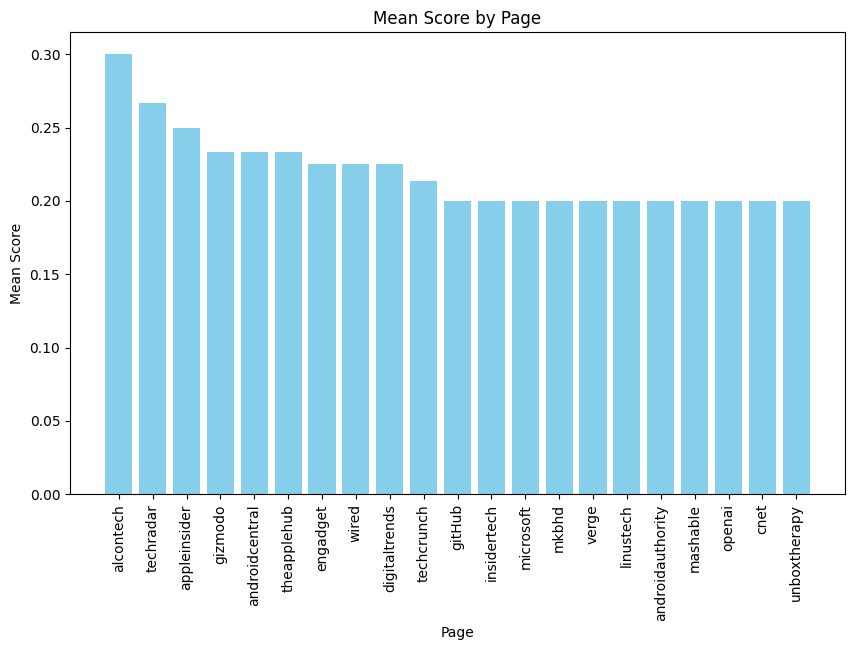

In [72]:
grouped_df = non_zero_df.groupby('page')['score'].mean().reset_index()
sorted_df = grouped_df.sort_values('score', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(sorted_df['page'], sorted_df['score'], color='skyblue')
plt.xlabel('Page')
plt.ylabel('Mean Score')
plt.title('Mean Score by Page')
plt.xticks(rotation=90)
plt.show()

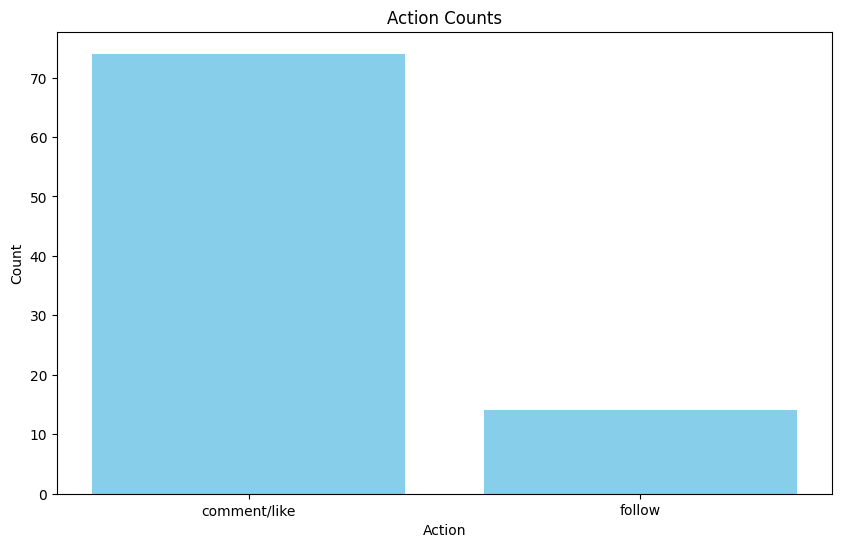

In [73]:
action_counts = non_zero_df['action'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(action_counts.index, action_counts.values, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Action Counts')
plt.show()